# DATATHON25 Neurotech Track

## DEFINITIONS
### COH: Coherence (i.e. phase coherence of two signals; delay in activation and response).
### AB: Power Spectrum Density (i.e. power distribution in frequency-space).
### F (frontal), P (parietal), O (occipital), T (temporal), Fp (frontopolar), C (central): Designates the lobe of the brain on which the electrode was placed. An odd number next to the letter represents the left side of the head while an even number represents the right side
### Fz, Cz, Pz: Designates the electrode is placed along the midline of the head.
### A (delta), B (theta), C (alpha), D (beta), E (high beta), F (gamma): Designates the frequency range of the wave measured. A = [0.5, 4) Hz, B = [4-8) Hz, C = [8-12) Hz, D = [12-25) Hz, E = [25-30) Hz, F = [30-40) Hz

## COLUMN NAMING CONVENTION
#### AB or COH
#### A, B, C, D, E, F
#### Frequency band name
#### Lowercase letter representing a single electrode starting from left-front to right-back of the head (e.g. a = Fp1, b = Fp2, c = F7, ..., r = O1, s = O2)
#### F, P, O, T, Fp, C, Fz, Cz, Pz (with corresponding odd or even number designation)
#### IF COH, another lowercase letter representing the second electrode
#### IF COH, another electrode designation with corresponding odd or even number

## COLUMN NAMING EXAMPLES
#### AB.A.delta.a.Fp1 = PSD value in the delta band measured by the electrode placed on the frontopolar lobe.
#### AB.B.theta.g.F8 = PSD value in the theta band by the electrode placed on the outermost part of the right frontal lobe.
#### COH.A.delta.a.Fp1.b.Fp2 = Coherence value in the delta band between the electrodes placed on the left and right frontopolar lobes.
## ===========================================================================================================================

In [339]:
# Install required libraries if not already installed
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scikit-learn

# Initialize required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from scipy.stats import entropy, differential_entropy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

### Define auxiliary functions used to process the data

In [309]:
def featureSelectionJMIM(feats, target, k):
    """ 
    Use the Joint Mutual Information Maximisation (JMIM) algorithm 
    developed by M. Bennasar, Y. Hicks, and R. Setchi (2015) to extract
    a subset of maximally-informative features from the full data
    INPUTS:
            - feats:      Pandas DataFrame whose columns are the features of 
                          the data. Must NOT contain missing or NaN values.
            - target:     Pandas Series whose values are class labels of each
                          observation in the dataset.
            - k:          Desired size of the subset of maximally-informative 
                          features.
    OUTPUTS:
            - features_k: Pandas DataFrame with k columns from the features
                          DataFrame that maximize the mutual information
                          with the target DataFrame
    """
    # Initialize dataframe to store the maximally-informative features subset
    features = feats.copy()
    features_k = pd.DataFrame(index = features.index)

    # Compute the probability mass function for the target variable, which is used
    # in the computation of the joint mutual information (JMI) between each feature and
    # the target variable
    unique_classes = pd.unique(target)
    target_probs = target.value_counts().to_numpy()/len(target)
    target_ent = entropy(target.value_counts().to_numpy()/len(target))
    
    # For selecting the first feature, initialize a variable to store the largest JMI 
    # value and a variable to record the column name of the feature that achieves this
    # largest JMI value. Then, append the column with the largest JMI to the features_k dataframe.
    max_jmi = 0
    max_jmi_feature = ''
    for col in features.columns:
        # Compute the entropy of the current feature. If the feature is binary, use
        # Shannon entropy. If the feature is numerical, use differential entropy.
        num_unique_vals = len(features[col].value_counts())
        joint_df = features[[col]].join(target.to_frame())
        if num_unique_vals == 2:
            # Compute the mutual information using the formula
            #            I(C,f) = S(f) + S(C) - S(C,f)
            # where C is the target variable, f is the feature variable, and S() is the entropy function
            col_ent = entropy(features[col].value_counts().to_numpy()/len(features[col])) 
            joint_ent = entropy(joint_df.value_counts().reset_index()['count']/len(joint_df))
            jmi_col = col_ent + target_ent - joint_ent
        else:
            # Compute the mixed mutual information using the formula
            #            I(C,f) = S(f) - sum_{i=0}^{m} P(C = c_i)*S(f|C = c_i)
            # where C is the target variable, f is the feature variable, and S() is the entropy function
            col_ent = differential_entropy(features[col])
            sum_MI = 0
            for i in range(len(unique_classes)):
                p_i = target_probs[i]
                f_i = joint_df.loc[joint_df.loc[:, target.name] == unique_classes[i], :]
                sum_MI += p_i*differential_entropy(f_i[col])
            
            jmi_col =  col_ent - sum_MI
        
        if jmi_col > max_jmi:
            max_jmi = jmi_col
            max_jmi_feature = col
    features_k = features_k.join(features[[max_jmi_feature]])
    features.drop(columns = max_jmi_feature, axis = 1, inplace = True)
    #print(features.head())
    
    # For each remaining column in the features dataframe, compute the JMI between
    # the new feature, the target, and each of the already-selected features. 
    # Then, append the column with that maximizes the mutual information while
    # minimizing the redundancy to the features_k dataframe. Repeat this until the 
    # features_k dataframe has k columns
    for i in range(1, k):
        max_jmi = 0
        max_jmi_feature = ''
        for column in features.columns:
            # Compute the entropy of the current feature. If the feature is binary, use
            # Shannon entropy. If the feature is numerical, use differential entropy.
            num_unique_vals = len(features[column].value_counts())
            joint_df = features[[column]].join(target.to_frame())
            if num_unique_vals == 2:
                # Compute the mutual information using the formula
                #            I(C,f) = S(f) + S(C) - S(C,f)
                # where C is the target variable, f is the feature variable, and S() is the entropy function
                col_ent = entropy(features[column].value_counts().to_numpy()/len(features[column])) 
                joint_ent = entropy(joint_df.value_counts().reset_index()['count']/len(joint_df))
                jmi_col = col_ent + target_ent - joint_ent
            else:
                # Compute the mixed mutual information using the formula
                #            I(C,f) = S(f) - sum_{i=0}^{m} P(C = c_i)*S(f|C = c_i)
                # where C is the target variable, f is the feature variable, and S() is the entropy function
                col_ent = differential_entropy(features[column])
                sum_MI = 0
                for j in range(len(unique_classes)):
                    p_i = target_probs[j]
                    f_i = joint_df.loc[joint_df.loc[:, target.name] == unique_classes[j], :]
                    sum_MI += p_i*differential_entropy(f_i[column])
                
                jmi_col =  col_ent - sum_MI
            
            if jmi_col > max_jmi:
                max_jmi = jmi_col
                max_jmi_feature = column
        features_k = features_k.join(features[[max_jmi_feature]])
        features.drop(columns = max_jmi_feature, axis = 1, inplace = True)
        #print(features_k.head())

    # Output the features_k dataframe
    return features_k

In [343]:
def letter2band(letter):
    """
    Converts from a 'letter' designation to the name of the frequency band
    corresponding to that letter
    INPUTS:
            - letter:    char object corresponding to the letter designation of a specific frequency band
            
    OUTPUTS:
            - band_name: string name of the frequency band corresponding to the input letter designation
    """
    conversion_dict = {'A': 'delta', 'B': 'theta', 'C': 'alpha', 'D': 'beta', 'E': 'highbeta', 'F': 'gamma'}

    return conversion_dict[letter]

def letter2lobe(letter):
    """
    Converts from a 'letter' designation to the name of the lobe of the brain where the
    electrode is placed
    INPUTS:
            - letter:    char object corresponding to the letter designation of a specific lobe
            
    OUTPUTS:
            - band_name: string name of the lobe corresponding to the input letter designation
    """
    conversion_dict = {'a': 'Fp1', 'b': 'Fp2', 'c': 'F7', 'd':'F3', 'e': 'Fz', 'f': 'F4', 
                       'g': 'F8', 'h': 'T3', 'i': 'C3', 'j': 'Cz', 'k': 'C4', 'l': 'T4', 
                       'm': 'T5', 'n': 'P3', 'o':'Pz', 'p': 'P4', 'q': 'T6', 'r': 'O1', 's': 'O2'}

    return conversion_dict[letter]

### Load the training data for the model

In [43]:
# Import training data into a dataframe and display the first 5 rows
train_set_filename = "Train_and_Validate_EEG.csv"
train_set = pd.read_csv(train_set_filename)
train_set.head()

,ID,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,F,31.55,2016.4.7,16.0,103.0,Mood disorder,Depressive disorder,48.843890,46.533704,...,84.825697,62.094883,49.639937,61.347225,81.630630,39.464753,72.168580,30.893891,74.038603,51.237679
1,2,M,25.00,2018.3.23,16.0,115.0,Healthy control,Healthy control,34.108015,22.838567,...,77.398455,48.282117,73.185133,66.742485,49.466312,59.270167,66.639938,40.297206,55.547526,63.630547
2,3,M,26.20,2015.4.10,16.0,83.0,Schizophrenia,Schizophrenia,31.084064,28.212342,...,91.510025,51.974239,62.571143,75.509166,56.460421,64.001966,78.424703,53.494830,66.581021,80.202968
3,4,M,21.00,2016.5.13,15.0,NaN,Obsessive compulsive disorder,Obsessive compulsitve disorder,14.310468,13.947459,...,79.855172,42.420095,56.473788,54.241183,69.561898,41.384408,66.332780,30.034691,65.659003,54.662177
4,5,F,28.15,2018.7.14,18.0,101.0,Healthy control,Healthy control,21.763093,23.938428,...,38.160508,21.319727,32.967416,33.401386,37.406879,27.080760,39.050046,14.826695,32.285940,41.015604


In [397]:
# Get a summary of the data types of the columns of the dataset
train_set.dtypes.value_counts()

float64    1143
object        3
Name: count, dtype: int64

### Based on the first five rows and the summary of data types, it seems that the column data types of the PSD and COH values are all floats, as expected. The columns with data of type "object" are: "sex", "eeg.date", "main.disorder", "specific.disorder". The "ID" column seems to be the only column with "integer" data type.

### To start the data wrangling, let's make the values in the "ID" column the row indinces of the dataframe and drop the "eeg.date" column. While this column can be useful in answering a questions about the validity of diagnoses using EEG tests over time or in certain periods, it serves no purpose as a predictor variable.

In [45]:
# Change the row indices of the dataframe to be the values of the "ID" column
train_set.set_index('ID', inplace = True)
train_set.index.name = None

# Drop the "egg.date" column
train_set.drop('eeg.date', axis = 1, inplace = True)
train_set.head()

,sex,age,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
1,F,31.55,16.0,103.0,Mood disorder,Depressive disorder,48.843890,46.533704,25.924618,30.221841,...,84.825697,62.094883,49.639937,61.347225,81.630630,39.464753,72.168580,30.893891,74.038603,51.237679
2,M,25.00,16.0,115.0,Healthy control,Healthy control,34.108015,22.838567,20.646824,18.203362,...,77.398455,48.282117,73.185133,66.742485,49.466312,59.270167,66.639938,40.297206,55.547526,63.630547
3,M,26.20,16.0,83.0,Schizophrenia,Schizophrenia,31.084064,28.212342,30.467865,48.643000,...,91.510025,51.974239,62.571143,75.509166,56.460421,64.001966,78.424703,53.494830,66.581021,80.202968
4,M,21.00,15.0,NaN,Obsessive compulsive disorder,Obsessive compulsitve disorder,14.310468,13.947459,10.761600,13.844880,...,79.855172,42.420095,56.473788,54.241183,69.561898,41.384408,66.332780,30.034691,65.659003,54.662177
5,F,28.15,18.0,101.0,Healthy control,Healthy control,21.763093,23.938428,19.517805,24.859077,...,38.160508,21.319727,32.967416,33.401386,37.406879,27.080760,39.050046,14.826695,32.285940,41.015604


### Now let's deal with NaN and missing values. First, if any row has a missing value in the "main.disorder" column, we will drop that row since we cannot use it to train the model. Similarly, drop any columns that have all missing values. Second, we will split the dataframe into our "features" dataframe and our "target" dataframe. Then, for dealing with the missing values in the remaining columns, we will use the SimpleImputer estimator available in the Scikit-Learn library to replace these missing values with predictions based on the rest of the data.

In [248]:
# Remove any rows for which the column "main.disorder" has missing values
#print(train_set.shape)
train_set.dropna(subset = 'main.disorder', axis = 0, inplace = True)
train_set.dropna(axis = 1, how = 'all', inplace = True)
#print(train_set.shape)

# Split the dataframe into predictor and target variables
x_train = train_set.drop(['main.disorder', 'specific.disorder'], axis = 1)
y_train = train_set['main.disorder']
y_optional = train_set['specific.disorder']

# Use SimpleImputer to replace the missing values in the columns of the predictor dataframe.
# Since the dataframe contains both categorical and numerical data, we will have to impute them separately.
numerical_cols = x_train.columns[x_train.columns != 'sex']
print('Missing values before processing = {}'.format(x_train.isna().to_numpy().sum()))
x_train[['sex']] = SimpleImputer(strategy = 'most_frequent').fit_transform(x_train[['sex']])
for col in numerical_cols:
    x_train[col] = SimpleImputer(strategy = 'mean').fit_transform(x_train[[col]])
print('Missing values after processing = {}'.format(x_train.isna().to_numpy().sum()))

Missing values before processing = 25
Missing values after processing = 0


### Lastly for data preprocessing, we hot encode the categorical "sex" variable to use in our models

In [249]:
# Hot encode the 'sex' column and drop the original column
#print(x_train.shape)
x_train = x_train.drop('sex', axis = 1).join(pd.get_dummies(x_train['sex']))
#print(x_train.shape)

### We now examine the target variable to make sure the formatting is consistent throughout the values

In [48]:
# Output a sum of the counts for each unique value in the column
y_train.value_counts()

main.disorder
Mood disorder                         250
Addictive disorder                    171
Schizophrenia                         109
Trauma and stress related disorder    106
Anxiety disorder                       91
Healthy control                        87
Obsessive compulsive disorder          38
Name: count, dtype: int64

### For the initial exploratory data analysis, we need to first normalize the data and then reduce the dimensionality by using Recursive Feature Elimination (RFE).

In [176]:
feature_optimizer = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train, y_train)

print('Optimal number of features: {}'.format(feature_optimizer.n_features_))

Optimal number of features: 15


### Let's visualize the accuracy as a function of number of features used

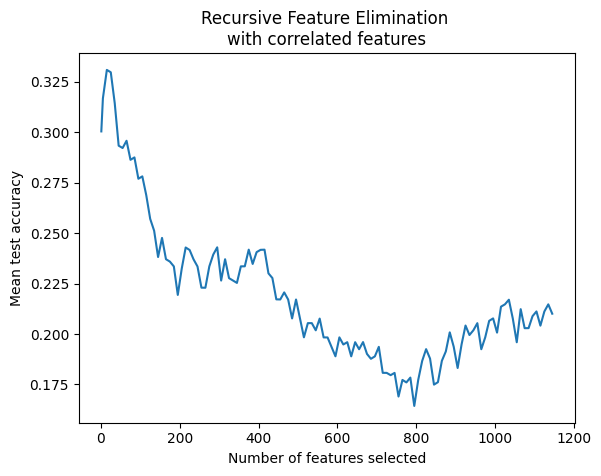

In [177]:
optimizer_results = pd.DataFrame(feature_optimizer.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Let's try a different method to reduce the dimensionality of the problem. We will employ the Joint Mutual Information Maximisation (JMIM) algorithm developed by M. Bennasar, Y. Hicks, and R. Setchi (2015) to extract a subset of maximally-informative features from the full data.

In [310]:
# Define how many features to select using the JMIM algorithm
num_features = [2, 10, 20, 30, 40, 50, 100]

# Initialize dictionaries to store the accuracy of the models and the names of the columns used to train the models
accuracy_scores_knn = {num_features[n]: [] for n in range(len(num_features))}
accuracy_scores_logistic = accuracy_scores_knn.copy()
accuracy_scores_ridge = accuracy_scores_knn.copy()
col_names = {num_features[n]: [] for n in range(len(num_features))}

In [311]:
# For each element in the num_features list, apply the JMIM algorithm to get a subset of maximally-informative 
# features and train a KNNClassifier model and evaluate the accuracy using 5-fold cross-validation
for k in num_features:
    # Apply the JMIM algorithm
    x_train_k = featureSelectionJMIM(x_train, y_train, k)

    # Train and evaluate the model
    col_names[k] = x_train_k.columns

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

### We will then train OneVsRest classifiers with different estimators using the subset of features and plot the different model accuracies as a function of the number of features used.

In [322]:
for k in num_features:
    x_train_k = x_train[col_names[k]]
    x_train_k_normed = StandardScaler().fit_transform(x_train_k)
    accuracy_scores_knn[k] = cross_val_score(OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 50)),
                                         x_train_k_normed, y_train, cv = 10)
    accuracy_scores_logistic[k] = cross_val_score(OneVsRestClassifier(LogisticRegression()),
                                                  x_train_k_normed, y_train, cv = 10)
    accuracy_scores_ridge[k] = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                               x_train_k_normed, y_train, cv = 10)

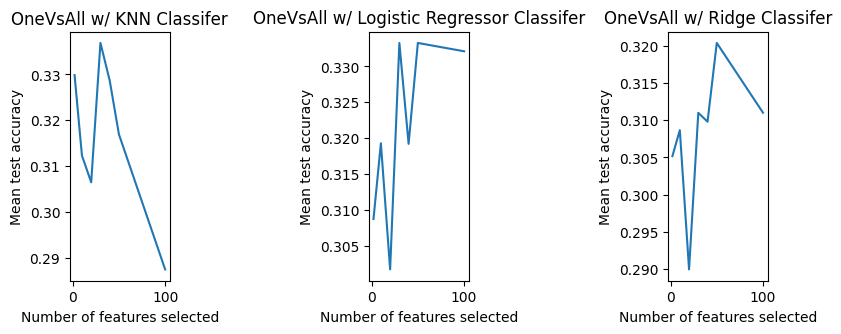

In [323]:
fig = plt.figure(figsize = (9, 4))
grid = fig.add_gridspec(nrows = 1, ncols = 3, wspace = 2)
axs = grid.subplots()
fig.suptitle = 'Feature Selection Using \nJoint Mutual Information Maximization'
axs[0].plot(accuracy_scores_knn.keys(), [np.mean(scores) for scores in accuracy_scores_knn.values()])
axs[0].set_title('OneVsAll w/ KNN Classifer')
axs[0].set_box_aspect(2.5)
axs[1].plot(accuracy_scores_logistic.keys(), [np.mean(scores) for scores in accuracy_scores_logistic.values()])
axs[1].set_title('OneVsAll w/ Logistic Regressor Classifer')
axs[1].set_box_aspect(2.5)
axs[2].plot(accuracy_scores_ridge.keys(), [np.mean(scores) for scores in accuracy_scores_ridge.values()])
axs[2].set_title('OneVsAll w/ Ridge Classifer')
axs[2].set_box_aspect(2.5)
for ax in axs.flat:
    ax.set(xlabel = 'Number of features selected', ylabel = 'Mean test accuracy')

plt.show()

### Based on the two feature selection methods, it seems that the multiclass accuracy of the model is not very high (maximum around 34%) when comparing all disorders against each other as well as against the healthy patients. 

### It's also worthwhile to analyze the distribution of the selected features among different EEG parameters such as PSD vs. COH, between the different frequency bands, between lobes, etc.
### We will restrict the analysis of the distribution to include only 20 maximally-informative features, which seems to be around the optimal number for all models considered.

In [344]:
# Define the column-name substrings that correspond to different EEG parameters in dictionaries
# whose key-value pairs correspond to parameter-count pairs
signal_features = {'AB': 0, 'COH': 0}
bands = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
lobes = {letter: 0 for letter in list(string.ascii_lowercase)[:19]}

# Populate the dictionaries by counting how many times each key appears in any of the column names
for feature in col_names[20]:
    # Split the string to determine the presence of each parameters
    feature = feature.split('.')
    if len(feature) > 1:
        if 'AB' in feature:
            signal_features['AB'] += 1
            bands[list(set(bands.keys()) & set(feature))[0]] += 1
            lobes[list(set(lobes.keys()) & set(feature))[0]] += 1 
        else:
            print(feature)
            signal_features['COH'] += 1
            bands[list(set(bands.keys()) & set(feature))[0]] += 1
            lobes_present = list(set(lobes.keys()) & set(feature))
            print(lobes_present)
            lobes[lobes_present[0]] += 1
            lobes[lobes_present[1]] += 1

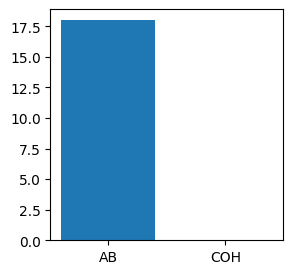

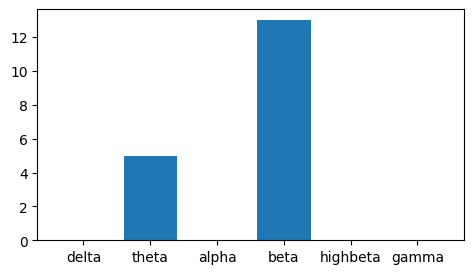

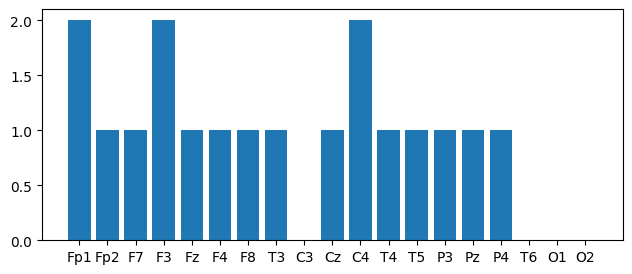

In [357]:
plt.figure(figsize = (3, 3))
plt.bar(signal_features.keys(), signal_features.values())
plt.show()

plt.figure(figsize = (5.5, 3))
plt.bar([letter2band(key) for key in bands.keys()], bands.values())
plt.show()

plt.figure(figsize = (7.5, 3))
plt.bar([letter2lobe(key) for key in lobes.keys()], lobes.values())
plt.show()

### Now, as in Park et al., (2021), let's divide the dataset into several subsets such that we can build up the comparison from a binary classification to a multiclass classification and see the effects of adding more classes.
### Schizophrenia

In [324]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Schizophrenia' or 'Healthy control'
bool_rows = [val == 'Schizophrenia' or val == 'Healthy control' for val in y_train.to_list()]
x_train_sch = x_train.loc[bool_rows, :]
y_train_sch = y_train.loc[bool_rows]

In [325]:
# Define how many features to select using the JMIM algorithm
num_features = [2, 10, 20, 30, 40, 50, 100]

# Initialize dictionaries to store the accuracy of the models and the names of the columns used to train the models
accuracy_scores_sch_knn = {num_features[n]: [] for n in range(len(num_features))}
accuracy_scores_sch_logistic = accuracy_scores_sch_knn.copy()
accuracy_scores_sch_ridge = accuracy_scores_sch_knn.copy()
col_names_sch = {num_features[n]: [] for n in range(len(num_features))}

# For each element in the num_features list, apply the JMIM algorithm to get a subset of maximally-informative 
# features and train a KNNClassifier model and evaluate the accuracy using 5-fold cross-validation
for k in num_features:
    # Apply the JMIM algorithm
    x_train_sch_k = featureSelectionJMIM(x_train_sch, y_train_sch, k)

    # Train and evaluate the model
    col_names_sch[k] = x_train_sch_k.columns

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [334]:
for k in num_features:
    x_train_sch_k_normed = StandardScaler().fit_transform(x_train_sch_k)
    accuracy_scores_sch_knn[k] = cross_val_score(OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 10)),
                                         x_train_sch_k_normed, y_train_sch, cv = 10)
    accuracy_scores_sch_logistic[k] = cross_val_score(OneVsRestClassifier(LogisticRegression()),
                                                  x_train_sch_k_normed, y_train_sch, cv = 10)
    accuracy_scores_sch_ridge[k] = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                               x_train_sch_k_normed, y_train_sch, cv = 10)

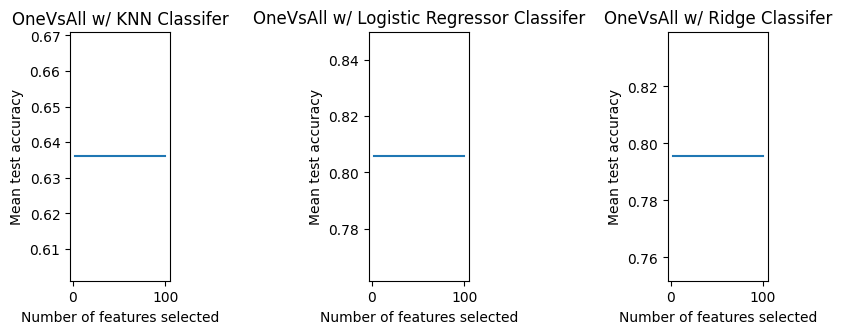

In [335]:
fig = plt.figure(figsize = (9, 4))
grid = fig.add_gridspec(nrows = 1, ncols = 3, wspace = 2)
axs = grid.subplots()
fig.suptitle = 'Feature Selection Using \nJoint Mutual Information Maximization'
axs[0].plot(accuracy_scores_sch_knn.keys(), [np.mean(scores) for scores in accuracy_scores_sch_knn.values()])
axs[0].set_title('OneVsAll w/ KNN Classifer')
axs[0].set_box_aspect(2.5)
axs[1].plot(accuracy_scores_sch_logistic.keys(), [np.mean(scores) for scores in accuracy_scores_sch_logistic.values()])
axs[1].set_title('OneVsAll w/ Logistic Regressor Classifer')
axs[1].set_box_aspect(2.5)
axs[2].plot(accuracy_scores_sch_ridge.keys(), [np.mean(scores) for scores in accuracy_scores_sch_ridge.values()])
axs[2].set_title('OneVsAll w/ Ridge Classifer')
axs[2].set_box_aspect(2.5)
for ax in axs.flat:
    ax.set(xlabel = 'Number of features selected', ylabel = 'Mean test accuracy')

plt.show()

In [365]:
feature_optimizer_sch = RFECV(estimator = LogisticRegression(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_sch, y_train_sch)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

Optimal number of features: 5


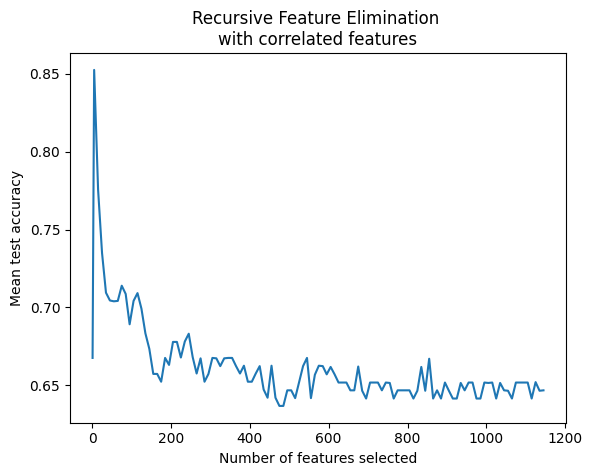

In [376]:
print('Optimal number of features: {}'.format(feature_optimizer_sch.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_sch.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ 15)

In [377]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_sch.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_sch_k = featureSelectionJMIM(x_train_sch, y_train_sch, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_sch = {num_features: x_train_sch_k.columns}

# Train and evaluate the LogisticRegression model
x_train_sch_k_normed = StandardScaler().fit_transform(x_train_sch_k)
accuracy_scores_sch = cross_val_score(OneVsRestClassifier(LogisticRegression()),
                                      x_train_sch_k_normed, y_train_sch, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [378]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_sch)))
print('feature columns used: {}'.format(col_names_sch[num_features]))

average accuracy score using 10-fold cross-validation is 0.8157894736842104
feature columns used: Index(['IQ', 'age', 'AB.D.beta.a.FP1', 'AB.D.beta.g.F8', 'AB.D.beta.b.FP2'], dtype='object')


### Addictive Disorder

In [363]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Addictive disorder' or 'Healthy control'
bool_rows = [val == 'Addictive disorder' or val == 'Healthy control' for val in y_train.to_list()]
x_train_AD = x_train.loc[bool_rows, :]
y_train_AD = y_train.loc[bool_rows]

In [374]:
feature_optimizer_AD = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_AD, y_train_AD)

Optimal number of features: 35


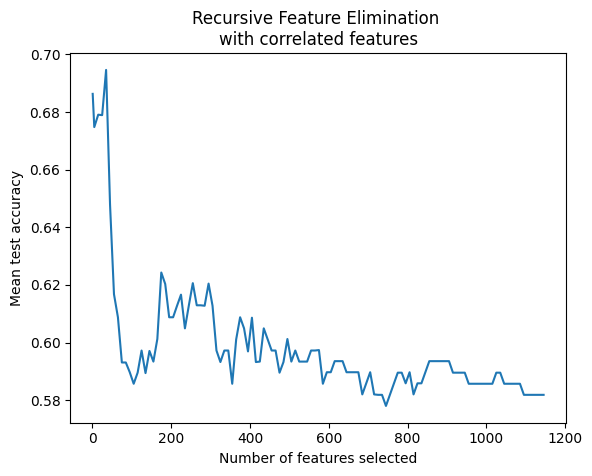

In [375]:
print('Optimal number of features: {}'.format(feature_optimizer_AD.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_AD.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ 35)

In [379]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_AD.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_AD_k = featureSelectionJMIM(x_train_AD, y_train_AD, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_AD = {num_features: x_train_AD_k.columns}

# Train and evaluate the LogisticRegression model
x_train_AD_k_normed = StandardScaler().fit_transform(x_train_AD_k)
accuracy_scores_AD = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_AD_k_normed, y_train_AD, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [380]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_AD)))
print('feature columns used: {}'.format(col_names_AD[num_features]))

average accuracy score using 10-fold cross-validation is 0.7093846153846153
feature columns used: Index(['age', 'IQ', 'AB.D.beta.m.T5', 'COH.B.theta.j.Cz.n.P3',
       'AB.D.beta.n.P3', 'AB.D.beta.h.T3', 'COH.B.theta.j.Cz.o.Pz',
       'COH.A.delta.n.P3.o.Pz', 'COH.A.delta.h.T3.j.Cz',
       'COH.B.theta.i.C3.j.Cz', 'COH.A.delta.d.F3.h.T3',
       'COH.B.theta.n.P3.o.Pz', 'COH.D.beta.j.Cz.n.P3', 'AB.D.beta.o.Pz',
       'COH.C.alpha.k.C4.o.Pz', 'COH.C.alpha.c.F7.m.T5', 'AB.C.alpha.n.P3',
       'COH.D.beta.i.C3.j.Cz', 'AB.D.beta.a.FP1', 'COH.C.alpha.n.P3.o.Pz',
       'COH.E.highbeta.m.T5.n.P3', 'COH.B.theta.i.C3.o.Pz', 'AB.D.beta.p.P4',
       'AB.F.gamma.h.T3', 'COH.E.highbeta.i.C3.n.P3', 'COH.B.theta.r.O1.s.O2',
       'AB.A.delta.m.T5', 'AB.D.beta.j.Cz', 'AB.D.beta.k.C4',
       'COH.B.theta.i.C3.n.P3', 'AB.F.gamma.s.O2', 'COH.D.beta.j.Cz.o.Pz',
       'AB.F.gamma.j.Cz', 'COH.A.delta.j.Cz.n.P3', 'COH.B.theta.f.F4.o.Pz'],
      dtype='object')


### Mood Disorder

In [385]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Mood disorder' or 'Healthy control'
bool_rows = [val == 'Mood disorder' or val == 'Healthy control' for val in y_train.to_list()]
x_train_MD = x_train.loc[bool_rows, :]
y_train_MD = y_train.loc[bool_rows]

In [393]:
feature_optimizer_MD = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_MD, y_train_MD)

Optimal number of features: 15


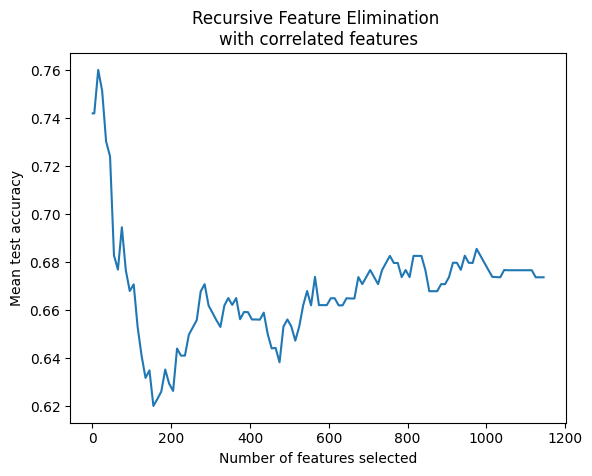

In [394]:
print('Optimal number of features: {}'.format(feature_optimizer_MD.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_MD.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ 15)

In [388]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_MD.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_MD_k = featureSelectionJMIM(x_train_MD, y_train_MD, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_MD = {num_features: x_train_MD_k.columns}

# Train and evaluate the LogisticRegression model
x_train_MD_k_normed = StandardScaler().fit_transform(x_train_MD_k)
accuracy_scores_MD = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_MD_k_normed, y_train_MD, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [395]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_MD)))
print('feature columns used: {}'.format(col_names_MD[num_features]))

average accuracy score using 10-fold cross-validation is 0.7688948306595366
feature columns used: Index(['IQ', 'age', 'AB.D.beta.b.FP2', 'COH.C.alpha.k.C4.o.Pz',
       'COH.B.theta.j.Cz.n.P3', 'AB.D.beta.p.P4', 'AB.D.beta.g.F8',
       'AB.A.delta.n.P3', 'COH.B.theta.a.FP1.o.Pz', 'COH.C.alpha.k.C4.n.P3',
       'AB.D.beta.o.Pz', 'COH.B.theta.f.F4.k.C4', 'COH.A.delta.a.FP1.o.Pz',
       'AB.A.delta.r.O1', 'AB.D.beta.a.FP1'],
      dtype='object')


### Obsessive-Compulsive Disorder

In [398]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Obsessive compulsive disorder' or 'Healthy control'
bool_rows = [val == 'Obsessive compulsive disorder' or val == 'Healthy control' for val in y_train.to_list()]
x_train_OCD = x_train.loc[bool_rows, :]
y_train_OCD = y_train.loc[bool_rows]

In [416]:
feature_optimizer_OCD = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_OCD, y_train_OCD)

Optimal number of features: 1


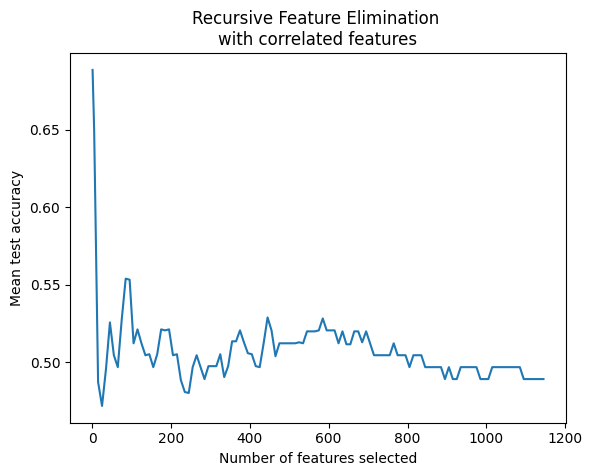

In [417]:
print('Optimal number of features: {}'.format(feature_optimizer_OCD.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_OCD.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ )

In [401]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_OCD.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_OCD_k = featureSelectionJMIM(x_train_OCD, y_train_OCD, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_OCD = {num_features: x_train_OCD_k.columns}

# Train and evaluate the LogisticRegression model
x_train_OCD_k_normed = StandardScaler().fit_transform(x_train_OCD_k)
accuracy_scores_OCD = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_OCD_k_normed, y_train_OCD, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI


In [402]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_OCD)))
print('feature columns used: {}'.format(col_names_OCD[num_features]))

average accuracy score using 10-fold cross-validation is 0.7044871794871795
feature columns used: Index(['age'], dtype='object')


### Anxiety Disorder

In [403]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Anxiety disorder' or 'Healthy control'
bool_rows = [val == 'Anxiety disorder' or val == 'Healthy control' for val in y_train.to_list()]
x_train_anx = x_train.loc[bool_rows, :]
y_train_anx = y_train.loc[bool_rows]

In [404]:
feature_optimizer_anx = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_anx, y_train_anx)

Optimal number of features: 5


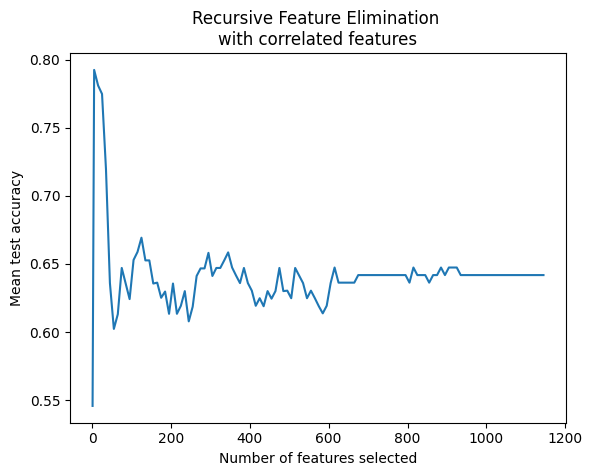

In [405]:
print('Optimal number of features: {}'.format(feature_optimizer_anx.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_anx.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ )

In [406]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_anx.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_anx_k = featureSelectionJMIM(x_train_anx, y_train_anx, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_anx = {num_features: x_train_anx_k.columns}

# Train and evaluate the LogisticRegression model
x_train_anx_k_normed = StandardScaler().fit_transform(x_train_anx_k)
accuracy_scores_anx = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_anx_k_normed, y_train_anx, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [407]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_anx)))
print('feature columns used: {}'.format(col_names_anx[num_features]))

average accuracy score using 10-fold cross-validation is 0.757843137254902
feature columns used: Index(['IQ', 'age', 'COH.A.delta.h.T3.j.Cz', 'COH.A.delta.a.FP1.k.C4',
       'AB.F.gamma.s.O2'],
      dtype='object')


### Trauma- and Stress-Related Disorder

In [408]:
# Create a subset of the x_train and y_train data that includes only the rows for which the value in the
# y_train columns is either 'Trauma and stress related disorder' or 'Healthy control'
bool_rows = [val == 'Trauma and stress related disorder' or val == 'Healthy control' for val in y_train.to_list()]
x_train_TSRD = x_train.loc[bool_rows, :]
y_train_TSRD = y_train.loc[bool_rows]

In [409]:
feature_optimizer_TSRD = RFECV(estimator = RidgeClassifier(),
                          step = 10,
                          cv = StratifiedKFold(10),
                          scoring= 'accuracy',
                          min_features_to_select = 1,
                          n_jobs=2).fit(x_train_TSRD, y_train_TSRD)

Optimal number of features: 5


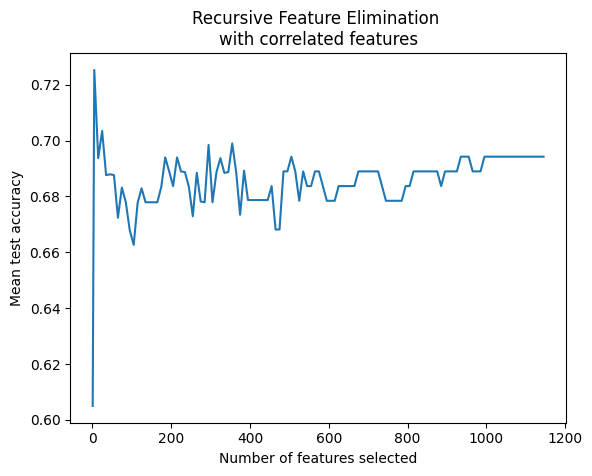

In [410]:
print('Optimal number of features: {}'.format(feature_optimizer_TSRD.n_features_))
optimizer_results = pd.DataFrame(feature_optimizer_TSRD.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.plot(optimizer_results['n_features'], optimizer_results['mean_test_score'])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Train the model on the optimal number of features (k ~ )

In [411]:
# Define how many features to select using the JMIM algorithm
num_features = feature_optimizer_TSRD.n_features_

# Apply the JMIM algorithm to get a subset of maximally-informative features, train a 
# LogisticRegression model, and evaluate the accuracy using 10-fold cross-validation
x_train_TSRD_k = featureSelectionJMIM(x_train_TSRD, y_train_TSRD, num_features)

# Store the number of features and the names of those features in a dictionary
col_names_TSRD = {num_features: x_train_TSRD_k.columns}

# Train and evaluate the LogisticRegression model
x_train_TSRD_k_normed = StandardScaler().fit_transform(x_train_TSRD_k)
accuracy_scores_TSRD = cross_val_score(OneVsRestClassifier(RidgeClassifier()),
                                      x_train_TSRD_k_normed, y_train_TSRD, cv = 10)

C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:57: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))
C:\Users\ricar\AppData\Local\Temp\ipykernel_6320\1122321767.py:97: RuntimeWarning: invalid value encountered in scalar subtract
  jmi_col =  col_ent - sum_MI
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_entropy.py:378

In [412]:
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_TSRD)))
print('feature columns used: {}'.format(col_names_TSRD[num_features]))

average accuracy score using 10-fold cross-validation is 0.7823684210526316
feature columns used: Index(['age', 'IQ', 'AB.D.beta.f.F4', 'AB.D.beta.k.C4', 'AB.D.beta.a.FP1'], dtype='object')


### Compile all the features that were selected by each of the binary classification steps and use only those features to train a final multiclass prediction model

In [445]:
col_names_JMIM = set([*col_names_sch.values()][0].to_list()) | set([*col_names_AD.values()][0].to_list()) |\
                 set([*col_names_MD.values()][0].to_list()) | set([*col_names_OCD.values()][0].to_list()) |\
                 set([*col_names_anx.values()][0].to_list()) | set([*col_names_TSRD.values()][0].to_list())
x_train_JMIM = x_train[list(col_names_JMIM)]
x_train_JMIM_normed = StandardScaler().fit_transform(x_train_JMIM)

In [447]:
model_JMIM = OneVsRestClassifier(LogisticRegression()).fit(x_train_JMIM_normed, y_train)

In [448]:
accuracy_scores_JMIM = cross_val_score(OneVsRestClassifier(LogisticRegression()),
                                       x_train_JMIM_normed, y_train, cv = 10)
print('average accuracy score using 10-fold cross-validation is {}'.format(np.mean(accuracy_scores_JMIM)))
print('feature columns used: {}'.format(col_names_JMIM))

average accuracy score using 10-fold cross-validation is 0.2851983584131327
feature columns used: {'COH.A.delta.h.T3.j.Cz', 'COH.A.delta.a.FP1.o.Pz', 'COH.C.alpha.n.P3.o.Pz', 'COH.A.delta.a.FP1.k.C4', 'AB.D.beta.m.T5', 'COH.E.highbeta.i.C3.n.P3', 'AB.D.beta.f.F4', 'COH.A.delta.j.Cz.n.P3', 'AB.C.alpha.n.P3', 'AB.D.beta.o.Pz', 'AB.D.beta.h.T3', 'AB.D.beta.j.Cz', 'COH.B.theta.a.FP1.o.Pz', 'COH.A.delta.d.F3.h.T3', 'AB.F.gamma.h.T3', 'AB.D.beta.b.FP2', 'AB.D.beta.n.P3', 'COH.B.theta.i.C3.j.Cz', 'COH.B.theta.f.F4.k.C4', 'COH.B.theta.r.O1.s.O2', 'AB.A.delta.m.T5', 'COH.C.alpha.c.F7.m.T5', 'COH.B.theta.j.Cz.n.P3', 'COH.C.alpha.k.C4.n.P3', 'COH.C.alpha.k.C4.o.Pz', 'COH.B.theta.f.F4.o.Pz', 'AB.A.delta.r.O1', 'AB.D.beta.g.F8', 'age', 'COH.B.theta.n.P3.o.Pz', 'COH.D.beta.j.Cz.n.P3', 'AB.D.beta.a.FP1', 'IQ', 'COH.E.highbeta.m.T5.n.P3', 'COH.B.theta.j.Cz.o.Pz', 'AB.F.gamma.j.Cz', 'AB.F.gamma.s.O2', 'AB.A.delta.n.P3', 'COH.D.beta.j.Cz.o.Pz', 'AB.D.beta.k.C4', 'COH.B.theta.i.C3.o.Pz', 'COH.A.delta.n.P